In [1]:
import catboost

In [3]:
from lifelines.datasets import load_rossi

In [4]:
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi

In [5]:
rossi_df = load_rossi()

In [9]:
import numpy as np
from catboost import Pool, CatBoostRegressor

In [10]:
from time import sleep

In [1796]:
class ProportionalLikelihood(object):
    reg = None
    
    def __init__(self, reg):
        self.reg = reg
        
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return True
    
    def set_unique_time(self, t):
        t = t.copy()
        t = t.astype(float)
        for value in np.unique(t):
            t[t == value] += np.arange(t[t == value].shape[0]) / (100 * t[t == value].shape[0])
        return t

    def evaluate(self, h, t, sigma, der1_test=False, loss_test=False):
        t = self.set_unique_time(t)
        N = t.shape[0]
        
        initial_h = h[0] 
        h = np.exp(h[0])
        
        assert np.unique(t).shape[0] == t.shape[0], "All t should be unique"
        
        sorted_h = h[np.argsort(t)]
        cumsum_h = np.cumsum(sorted_h[::-1])[::-1]
        eloss = (sorted_h / cumsum_h)
        
        reg_part = (initial_h ** 2).sum()
        
        loss_sum = -np.log(eloss).sum() + self.reg * reg_part
        
        if loss_test:
            return sorted_h, cumsum_h
        
        if der1_test:
            return loss_sum
        
        return loss_sum, N#np.sum(1 - sigma)#-np.log(loss).sum(), 
    
    def calc_ders_range(self, h, t, sigma, der1_test=False, der2_test=False):
        N = t.shape[0]
        t = self.set_unique_time(t)
        
        initial_h = h
        h = np.exp(h) # Possible math overflow!
        
        sorted_h_indices = np.argsort(t)
        rev_sorted_h_indices = np.argsort(sorted_h_indices)
        
        initial_sorted_h = initial_h[sorted_h_indices]
        sorted_h = h[sorted_h_indices] # hi
        cumsum_h = np.cumsum(sorted_h[::-1])[::-1] #Ci
        
        h_frac = 1 / sorted_h 
        cumsum_h_frac = 1 / cumsum_h 
        cumsum_h_frac_cumsum = np.cumsum(cumsum_h_frac)
        
        der1_part = (cumsum_h_frac_cumsum - h_frac)
        
        der1 = der1_part * sorted_h + 2 * self.reg * initial_sorted_h
        
        if der1_test:
            print(der1)
            return der1[rev_sorted_h_indices]
        
        h_frac_square = 1 / (sorted_h ** 2)
        cumsum_h_frac_square = 1 / (cumsum_h ** 2)
        cumsum_h_frac_square_cumsum = np.cumsum(cumsum_h_frac_square)
        
        der2_part = h_frac_square - cumsum_h_frac_square_cumsum
        
        der2 = sorted_h * (der1_part + der2_part * sorted_h) + self.reg * 2 * np.sign(initial_sorted_h)
        
        if der2_test:
            return der2[rev_sorted_h_indices]
        
        return np.vstack([
            -der1[rev_sorted_h_indices],
            -der2[rev_sorted_h_indices]
        ]).T

# Debugging derivatives

In [1797]:
loss = ProportionalLikelihood(reg=0)

In [1801]:
# Correct risk
loss.evaluate(
    (np.array([2, 3, 8]), ), 
    np.array([3, 2, 1]), 
    np.array([0, 0, 0]),
#     loss_test=True
)

(0.32243617210995773, 3)

In [1802]:
# One element is wrong
loss.evaluate(
    (np.array([2, 3, 8]), ), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
#     loss_test=True
)

(6.015889833080853, 3)

In [1803]:
# Everything is incorrect
loss.evaluate(
    (np.array([2, 3, 8]), ), 
    np.array([2, 3, 8]), 
    np.array([0, 0, 0]),
#     loss_test=True
)

(11.015889833080852, 3)

In [1800]:
loss.evaluate(
    (np.array([2, 3, 8]), ), 
    np.array([1, 2, 3]), 
    np.array([0, 0, 0]),
#     loss_test=True
)

(11.015889833080852, 3)

In [1679]:
loss.evaluate(
    (np.array([2, 3, 8]), ), 
    np.array([1, 0, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
)

6.00247568513773

In [1680]:
delta = 0.001

In [1681]:
# # First derivative, i=1
((loss.evaluate(
    (np.array([2 + delta, -3, 8]), ), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
) - loss.evaluate(
    (np.array([2, -3, 8]), ), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
)) / delta)

0.0

In [1652]:
# First derivative, i=2
((loss.evaluate(
    (np.array([2, -3 + delta, 8]), ), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
) - loss.evaluate(
    (np.array([2, -3, 8]), ), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
)) / delta)


3.337823439863996e-05

In [1653]:
# First derivative, i=3
((loss.evaluate(
    (np.array([2, -3, 8 + delta]), ), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
) - loss.evaluate(
    (np.array([2, -3, 8]), ), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
)) / delta)


0.9974953059481706

In [1654]:
loss.calc_ders_range(
    np.array([2, -3, 8]), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
)

[-9.97527418e-01  9.97494056e-01  3.33615481e-05]


array([-9.97527418e-01,  3.33615481e-05,  9.97494056e-01])

In [1655]:
# Second derivative, i = 1
(
    loss.calc_ders_range(
        np.array([2 + delta, -3, 8]), 
        np.array([0, 1, 2]), 
        np.array([0, 0, 0]),
        der1_test=True
    ) - loss.calc_ders_range(
        np.array([2, -3, 8]), 
        np.array([0, 1, 2]), 
        np.array([0, 0, 0]),
        der1_test=True
    )
)[0] / delta

[-0.99752495 -0.99996664  1.99749159]
[-0.99752742 -0.99996664  1.99749406]


0.002467695841779083

In [1656]:
# Second derivative, i = 2
(
    loss.calc_ders_range(
        np.array([2, -3 + delta, 8]), 
        np.array([0, 1, 2]), 
        np.array([0, 0, 0]),
        der1_test=True
    ) - loss.calc_ders_range(
        np.array([2, -3, 8]), 
        np.array([0, 1, 2]), 
        np.array([0, 0, 0]),
        der1_test=True
    )
)[1] / delta

[-0.99752742 -0.99996661  1.99749402]
[-0.99752742 -0.99996664  1.99749406]


3.33776771777039e-05

In [1657]:
# Second derivative, i = 3
(
    loss.calc_ders_range(
        np.array([2, -3, 8 + delta]), 
        np.array([0, 1, 2]), 
        np.array([0, 0, 0]),
        der1_test=True
    ) - loss.calc_ders_range(
        np.array([2, -3, 8]), 
        np.array([0, 1, 2]), 
        np.array([0, 0, 0]),
        der1_test=True
    )
)[2] / delta

[-0.99752988 -0.99996667  1.99749655]
[-0.99752742 -0.99996664  1.99749406]


0.0024985036235491975

In [1658]:
loss.calc_ders_range(
    np.array([2, -3, 8]), 
    np.array([0, 1, 2]), 
    np.array([0, 0, 0]),
    der2_test=True
)

array([2.46646830e-03, 3.33609916e-05, 2.49974691e-03])

### Difficult cases

In [1659]:
# test_t = np.array([20, 17, 25, 23, 37, 25, 46, 28, 24, 50])
# test_h = np.array([ 1.0579772  , 1.3556235 ,  1.59537611 , 0.42585979 , 1.44649814 , 0.5426282,
#  -2.33794021,  0.20124088, -0.42943875, -1.66655973])

test_t = np.array([20, 17, 25, 23, 37, 25.1, 46, 28])
test_h = np.array([ 1.0579772  , 1.3556235 ,  1.59537611 , 0.42585979 , 1.44649814 , 0.5426282,
 -2.33794021,  0.20124088])
test_sigma = np.zeros(test_t.shape[0])

In [1660]:
np.argsort(test_t)

array([1, 0, 3, 2, 5, 7, 4, 6])

In [1661]:
def get_numeric_derivative(h, t, sigma, i):
    h_increased = h.copy()
    h_increased[i] += delta
    
    return ((loss.evaluate(
        (h_increased, ), 
        t, 
        sigma,
        der1_test=True
    ) - loss.evaluate(
        (h, ), 
        t, 
        sigma,
        der1_test=True
    )) / delta)

In [1662]:
np.array([get_numeric_derivative(test_h, test_t, test_sigma, i) for i in range(test_h.shape[0])])

array([-0.68620013, -0.81077798,  0.2993728 , -0.72182604,  2.44357478,
       -0.31033801,  0.07826807, -0.29005566])

In [1663]:
loss.calc_ders_range(
    test_h, 
    test_t, 
    test_sigma,
#     der1_test=True
)

array([[ 0.68633213, -0.2639374 ],
       [ 0.81085468, -0.15336937],
       [-0.29894182, -0.8618662 ],
       [ 0.72195188, -0.25160388],
       [-2.44295454, -1.24041866],
       [ 0.31062828, -0.58041316],
       [-0.07822951, -0.0770924 ],
       [ 0.2903589 , -0.60634898]])

# Model

In [1664]:
model = CatBoostRegressor(
    loss_function=loss, 
    eval_metric=loss, 
    iterations=1000, 
    learning_rate=0.01
)

In [1665]:
N = 10000

In [1666]:
rossi2_df = rossi_df[rossi_df['week'] < 52].iloc[0:N].reset_index(drop=True)

In [1667]:
X = rossi2_df.drop(columns=['week'])

In [1668]:
t = rossi2_df['week']

In [1669]:
sigma = rossi2_df['arrest']

In [1670]:
import numba

In [1671]:
import matplotlib.pyplot as plt

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 410.0969243	total: 3.31ms	remaining: 3.31s
1:	learn: 409.9896456	total: 6.35ms	remaining: 3.17s
2:	learn: 409.8872192	total: 9.98ms	remaining: 3.32s
3:	learn: 409.7391290	total: 13.4ms	remaining: 3.34s
4:	learn: 409.5834469	total: 16.5ms	remaining: 3.27s
5:	learn: 409.5070608	total: 19.4ms	remaining: 3.22s
6:	learn: 409.3994388	total: 22.3ms	remaining: 3.17s
7:	learn: 409.2246950	total: 25.3ms	remaining: 3.14s
8:	learn: 409.0941427	total: 28.4ms	remaining: 3.12s
9:	learn: 408.9443217	total: 31.1ms	remaining: 3.08s
10:	learn: 408.7768803	total: 33.8ms	remaining: 3.04s
11:	learn: 408.5832585	total: 36.5ms	remaining: 3s
12:	learn: 408.4778834	total: 39.4ms	remaining: 2.99s
13:	learn: 408.3262011	total: 42ms	remaining: 2.96s
14:	learn: 408.1875565	total: 44.7ms	remaining: 2.94s
15:	learn: 408.0121014	total: 47.6ms	remaining: 2.93s
16:	learn: 407.8499854	total: 50.3ms	remaining: 2.91s
17:	learn: 407.6858679	total: 52.9ms	remaining: 2.88s
18:	learn: 407.5592556	total: 55.7ms	remain

208:	learn: 391.2502568	total: 588ms	remaining: 2.23s
209:	learn: 391.1896966	total: 591ms	remaining: 2.22s
210:	learn: 391.1469252	total: 593ms	remaining: 2.22s
211:	learn: 391.0841030	total: 596ms	remaining: 2.22s
212:	learn: 391.0453054	total: 599ms	remaining: 2.21s
213:	learn: 390.9952632	total: 602ms	remaining: 2.21s
214:	learn: 390.9323443	total: 605ms	remaining: 2.21s
215:	learn: 390.8115523	total: 612ms	remaining: 2.22s
216:	learn: 390.7701491	total: 615ms	remaining: 2.22s
217:	learn: 390.7332195	total: 619ms	remaining: 2.22s
218:	learn: 390.6962413	total: 622ms	remaining: 2.22s
219:	learn: 390.6503439	total: 624ms	remaining: 2.21s
220:	learn: 390.6075249	total: 627ms	remaining: 2.21s
221:	learn: 390.5071051	total: 630ms	remaining: 2.21s
222:	learn: 390.4163414	total: 632ms	remaining: 2.2s
223:	learn: 390.3705243	total: 635ms	remaining: 2.2s
224:	learn: 390.3241033	total: 638ms	remaining: 2.2s
225:	learn: 390.2568200	total: 640ms	remaining: 2.19s
226:	learn: 390.2068322	total: 

409:	learn: 380.6947285	total: 1.17s	remaining: 1.69s
410:	learn: 380.6336066	total: 1.18s	remaining: 1.69s
411:	learn: 380.5813416	total: 1.18s	remaining: 1.69s
412:	learn: 380.5622053	total: 1.18s	remaining: 1.68s
413:	learn: 380.4662353	total: 1.19s	remaining: 1.68s
414:	learn: 380.4154066	total: 1.19s	remaining: 1.68s
415:	learn: 380.3920163	total: 1.19s	remaining: 1.67s
416:	learn: 380.3517983	total: 1.19s	remaining: 1.67s
417:	learn: 380.2972629	total: 1.2s	remaining: 1.67s
418:	learn: 380.2688049	total: 1.2s	remaining: 1.66s
419:	learn: 380.2298334	total: 1.2s	remaining: 1.66s
420:	learn: 380.1551279	total: 1.21s	remaining: 1.66s
421:	learn: 380.0938520	total: 1.21s	remaining: 1.66s
422:	learn: 379.9930094	total: 1.21s	remaining: 1.66s
423:	learn: 379.9476774	total: 1.22s	remaining: 1.65s
424:	learn: 379.9207856	total: 1.22s	remaining: 1.65s
425:	learn: 379.8735787	total: 1.22s	remaining: 1.65s
426:	learn: 379.8394561	total: 1.22s	remaining: 1.64s
427:	learn: 379.8336592	total: 

616:	learn: 371.4085956	total: 1.76s	remaining: 1.09s
617:	learn: 371.3628404	total: 1.77s	remaining: 1.09s
618:	learn: 371.2998582	total: 1.77s	remaining: 1.09s
619:	learn: 371.2424660	total: 1.77s	remaining: 1.09s
620:	learn: 371.1713840	total: 1.77s	remaining: 1.08s
621:	learn: 371.1162348	total: 1.78s	remaining: 1.08s
622:	learn: 371.0463932	total: 1.79s	remaining: 1.08s
623:	learn: 371.0154728	total: 1.79s	remaining: 1.08s
624:	learn: 370.9336341	total: 1.79s	remaining: 1.07s
625:	learn: 370.9077058	total: 1.8s	remaining: 1.08s
626:	learn: 370.8821159	total: 1.81s	remaining: 1.07s
627:	learn: 370.8745650	total: 1.81s	remaining: 1.07s
628:	learn: 370.8271841	total: 1.81s	remaining: 1.07s
629:	learn: 370.8066710	total: 1.82s	remaining: 1.07s
630:	learn: 370.7705959	total: 1.82s	remaining: 1.06s
631:	learn: 370.7286050	total: 1.82s	remaining: 1.06s
632:	learn: 370.7227175	total: 1.83s	remaining: 1.06s
633:	learn: 370.6913232	total: 1.83s	remaining: 1.06s
634:	learn: 370.6557761	total

809:	learn: 364.7825079	total: 2.35s	remaining: 551ms
810:	learn: 364.7621411	total: 2.35s	remaining: 549ms
811:	learn: 364.7432846	total: 2.36s	remaining: 546ms
812:	learn: 364.7223167	total: 2.36s	remaining: 543ms
813:	learn: 364.7073492	total: 2.36s	remaining: 540ms
814:	learn: 364.6865754	total: 2.37s	remaining: 537ms
815:	learn: 364.6613472	total: 2.37s	remaining: 534ms
816:	learn: 364.6352857	total: 2.37s	remaining: 531ms
817:	learn: 364.5867355	total: 2.37s	remaining: 528ms
818:	learn: 364.5666501	total: 2.38s	remaining: 525ms
819:	learn: 364.5443776	total: 2.38s	remaining: 522ms
820:	learn: 364.5264486	total: 2.38s	remaining: 519ms
821:	learn: 364.5087643	total: 2.38s	remaining: 516ms
822:	learn: 364.4378195	total: 2.39s	remaining: 514ms
823:	learn: 364.4050183	total: 2.39s	remaining: 511ms
824:	learn: 364.3767076	total: 2.39s	remaining: 508ms
825:	learn: 364.3524748	total: 2.4s	remaining: 505ms
826:	learn: 364.3256008	total: 2.4s	remaining: 503ms
827:	learn: 364.3132719	total:

[20 17 25 23 37 25 46 28 24 50 10 20 50  6 49 43  5 27 22 18 24  2 26 49
 21 48  8 49  8 13  8 33 11 37 44  9 17 16  3 45 28 16 15 14  7 43 46 40
 14  8 25 17 37 32 12 18 14 38 24 20 32 31 20 40 42 26 47 40 21  1 43 24
 11 33 46 36 18 50 34 35 39  9 34 44 35 30 39 19 43 48 37 20 36 30 42 26
 40 35 46 49 49 35 27 45  4 36  8 15 19 12] [ 0.96018627  0.97706224  0.83836704  0.54070345 -0.13567303  0.00636109
 -0.46374951  0.25580528  0.85942408 -1.02013564  1.9992742   0.23888033
 -2.04845183 -0.15510628 -0.83537554 -0.35999109  0.57602164  0.93851429
  0.82632378  0.4565681   0.04902474  2.42745568  0.32300212 -0.46447581
  1.16220018 -0.15510628  2.22400878 -0.89723187  0.51890376  0.51844936
  1.70944952  0.26250172 -0.06032798 -0.06819172 -0.82879076  1.84664984
  0.41517692  1.37590466  1.73502847 -0.08767764  0.05063262  1.35550516
  0.38611868  1.68337165  0.38710133 -0.34504803 -0.36066732 -0.30168083
  0.34565909  0.65826381  0.76437323 -0.08767764 -0.50925391  0.0527827
  1.6528

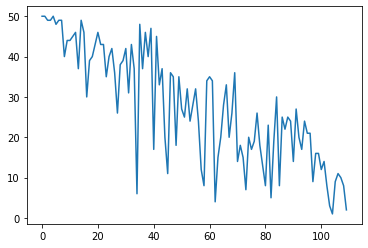

In [1672]:
for i in range(0, 1):
    if i == 0:
        model.fit(X, t, sample_weight=sigma, verbose_eval=True)
    else:
        model.fit(X, t, sample_weight=sigma, verbose_eval=True, init_model=model)
    prediction = model.predict(X)
    
    print(t.values, prediction)
    
    t[np.argsort(prediction)].reset_index(drop=True).plot()
    plt.show()

# Survival curve

In [1729]:
def calculate_base_risk(h, t):
    d = np.arange(t.shape[0]) + 1
    cumsum_h = np.cumsum(h[::-1])[::-1]
    
    return d / cumsum_h

In [1730]:
def get_unique_time(t):
    t = t.copy()
    t = t.astype(float)
    for value in np.unique(t):
        t[t == value] += np.arange(t[t == value].shape[0]) / (100 * t[t == value].shape[0])
    return t

In [1731]:
train_h = np.exp(model.predict(X))
train_t = get_unique_time(t)

In [1739]:
sorted_train_t = np.sort(train_t)

In [1740]:
h_base = calculate_base_risk(train_h, train_t)

In [1741]:
H_base = -np.cumsum(h_base)

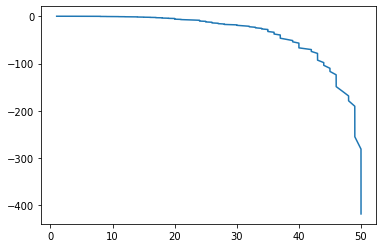

In [1742]:
plt.plot(sorted_train_t, H_base)

In [1743]:
S_base = np.exp(H_base)

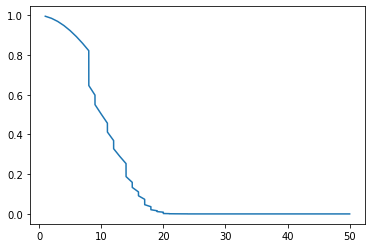

In [1744]:
plt.plot(sorted_train_t, S_base)

In [1753]:
S_matrix = S_base.reshape(1, -1) ** train_h.reshape(-1, 1)

(0.0, 25.0)

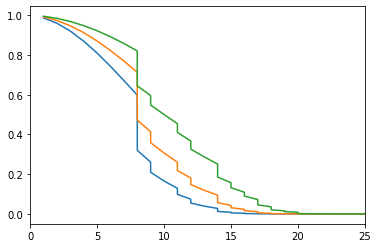

In [1767]:
plt.plot(sorted_train_t, S_matrix[0])
plt.plot(sorted_train_t, S_matrix[3])
plt.plot(sorted_train_t, S_matrix[5])
plt.xlim(0, 25)